In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import re
import ast
import scipy.stats as sp
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

## Dataframe Cleaning

In [24]:
df = pd.read_csv("../data/tokenized-data.csv")

In [25]:
# dropping index column that was passed along
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[0], axis=1)

In [26]:
display(df[0:3])

,fullname,html,is_retweet,likes,replies,retweet_id,retweeter_userid,retweeter_username,retweets,text_x,timestamp,timestamp_epochs,tweet_id,tweet_url,user_id,username,url_x,url_y,text_y,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity
0,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,409,46,NaN,NaN,NaN,54,"In many ways, Tyler Perry still feels like the...",2019-10-14 23:45:05,2019-10-14 23:45:05,1183891505553068032,/nytimes/status/1183891505553068033,807095,nytimes,https://nyti.ms/2MfGkpT,https://nyti.ms/2MfGkpT,Cara Buckley Tyler Perry hears voices in his h...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ..."
1,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,70,81,NaN,NaN,NaN,18,"In Opinion\n\nRobert Leonard, the news directo...",2019-10-14 23:30:07,2019-10-14 23:30:07,1183887741622337536,/nytimes/status/1183887741622337536,807095,nytimes,https://nyti.ms/2OMm5TN,https://nyti.ms/2OMm5TN,Robert Leonard Mr Leonard is the author of Dee...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'is', '...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR..."
2,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,167,8,NaN,NaN,NaN,39,"In Opinion\n \n""I'm suffocating inside my mask...",2019-10-14 23:15:04,2019-10-14 23:15:04,1183883954346217472,/nytimes/status/1183883954346217473,807095,nytimes,https://nyti.ms/2ISx9Lj,https://nyti.ms/2ISx9Lj,Shuhan Fan and Luther Clement Ms Fan and Mr Cl...,"['Shuhan', 'Fan', 'and', 'Luther', 'Clement', ...",237,"[Shuhan Fan and Luther Clement, Ms Fan and Mr ...","['Shuhan', 'Fan', 'Luther', 'Clement', 'Ms', '...","{Shuhan: 'Shuhan', Fan: 'Fan', and: 'and', Lut...","Counter({'film': 6, 'Keeth': 5, 'Fan': 2, 'Lut...","{Shuhan: 'PROPN', Fan: 'PROPN', and: 'CCONJ', ...","{'ORG': ['Peter Westbrook Foundation ', 'the P..."


In [27]:
df.shape

(11177, 27)

In [28]:
# merging with Abram's by sentence features 

sentence_features = pd.read_pickle("../data/by_sentence_features.pkl")
sentence_features = sentence_features.set_index('url_x')
sentence_features

,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length
url_x,,,,,,,,,,,,,,,,,,,,
https://nyti.ms/2MfGkpT,3.687500,2.828125,1.625000,0.906250,1.003368,1.072613,0.772419,0.842893,2.894302,1.741689,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390
https://nyti.ms/2OMm5TN,3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753
https://nyti.ms/2ISx9Lj,3.333333,2.750000,1.166667,0.750000,0.252117,0.052602,1.009002,0.477594,2.839121,1.912875,1.337116,0.753778,-1.306829,-0.864689,0.204769,-0.868267,22.250000,-0.248484,-1.151573,11.250253
https://nyti.ms/2Mga6wf,5.324324,2.621622,2.378378,1.270270,0.912134,0.711977,0.722196,0.405114,2.991228,1.587299,1.815846,0.961730,0.832259,0.000715,0.145126,0.260045,29.000000,1.372602,2.702790,13.884444
https://nyti.ms/2pSoGB5,3.910256,2.213675,1.512821,1.102564,0.578987,0.902220,1.260976,1.176296,2.923279,1.842880,1.583799,1.228311,-0.107503,0.652947,1.612222,1.196215,23.213675,0.806188,0.455250,14.385752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://nyti.ms/2EK6vlI,4.548387,2.870968,1.290323,0.903226,0.157109,-0.140819,0.627138,1.010908,2.987069,1.910357,1.321452,1.164899,-0.672727,-1.194504,-0.852910,0.037861,22.580645,0.124105,-0.400953,13.265932
https://nyti.ms/2ENHfLr,3.661538,1.861538,1.169231,1.015385,1.292895,0.991595,0.914647,0.733865,3.073460,1.549969,1.193331,0.960018,1.709861,0.743699,0.002317,0.176293,21.061538,1.004052,0.187952,12.803658
https://nyti.ms/2EK5Nos,2.773196,1.494845,1.041237,0.484536,1.379286,1.131552,1.842030,2.649897,2.984352,1.684016,1.547293,0.855295,1.992111,0.494904,3.012972,9.556276,23.886598,2.472944,9.397168,24.480382


In [29]:
df = df.join(sentence_features, on='url_x')

In [30]:
print(df.shape)
display(df[0:3])

(11177, 47)


,fullname,html,is_retweet,likes,replies,retweet_id,retweeter_userid,retweeter_username,retweets,text_x,timestamp,timestamp_epochs,tweet_id,tweet_url,user_id,username,url_x,url_y,text_y,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length
0,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,409,46,NaN,NaN,NaN,54,"In many ways, Tyler Perry still feels like the...",2019-10-14 23:45:05,2019-10-14 23:45:05,1183891505553068032,/nytimes/status/1183891505553068033,807095,nytimes,https://nyti.ms/2MfGkpT,https://nyti.ms/2MfGkpT,Cara Buckley Tyler Perry hears voices in his h...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ...",3.687500,2.828125,1.625000,0.906250,1.003368,1.072613,0.772419,0.842893,2.894302,1.741689,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390
1,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,70,81,NaN,NaN,NaN,18,"In Opinion\n\nRobert Leonard, the news directo...",2019-10-14 23:30:07,2019-10-14 23:30:07,1183887741622337536,/nytimes/status/1183887741622337536,807095,nytimes,https://nyti.ms/2OMm5TN,https://nyti.ms/2OMm5TN,Robert Leonard Mr Leonard is the author of Dee...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'is', '...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753
2,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,167,8,NaN,NaN,NaN,39,"In Opinion\n \n""I'm suffocating inside my mask...",2019-10-14 23:15:04,2019-10-14 23:15:04,1183883954346217472,/nytimes/status/1183883954346217473,807095,nytimes,https://nyti.ms/2ISx9Lj,https://nyti.ms/2ISx9Lj,Shuhan Fan and Luther Clement Ms Fan and Mr Cl...,"['Shuhan', 'Fan', 'and', 'Luther', 'Clement', ...",237,"[Shuhan Fan and Luther Clement, Ms Fan and Mr ...","['Shuhan', 'Fan', 'Luther', 'Clement', 'Ms', '...","{Shuhan: 'Shuhan', Fan: 'Fan', and: 'and', Lut...","Counter({'film': 6, 'Keeth': 5, 'Fan': 2, 'Lut...","{Shuhan: 'PROPN', Fan: 'PROPN', and: 'CCONJ', ...","{'ORG': ['Peter Westbrook Foundation ', 'the P...",3.333333,2.750000,1.166667,0.750000,0.252117,0.052602,1.009002,0.477594,2.839121,1.912875,1.337116,0.753778,-1.306829,-0.864689,0.204769,-0.868267,22.250000,-0.248484,-1.151573,11.250253


In [31]:
# joining with text data
text = pd.read_pickle("../data/clean_text.pkl")
text = text.rename({'url': 'url_x'}, axis=1)
text = text.set_index('url_x')

In [32]:
text_nodups = text.drop_duplicates()
print(text.shape)
print(text_nodups.shape)
print(df.shape)

(11470, 1)
(8840, 1)
(11177, 47)


In [33]:
df2 = df.join(text_nodups, on='url_x')

In [34]:
display(df2[0:3])

,fullname,html,is_retweet,likes,replies,retweet_id,retweeter_userid,retweeter_username,retweets,text_x,timestamp,timestamp_epochs,tweet_id,tweet_url,user_id,username,url_x,url_y,text_y,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length,text
0,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,409,46,NaN,NaN,NaN,54,"In many ways, Tyler Perry still feels like the...",2019-10-14 23:45:05,2019-10-14 23:45:05,1183891505553068032,/nytimes/status/1183891505553068033,807095,nytimes,https://nyti.ms/2MfGkpT,https://nyti.ms/2MfGkpT,Cara Buckley Tyler Perry hears voices in his h...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ...",3.687500,2.828125,1.625000,0.906250,1.003368,1.072613,0.772419,0.842893,2.894302,1.741689,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390,Cara Buckley AT LA NT A — Tyler Perry hears v...
1,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,70,81,NaN,NaN,NaN,18,"In Opinion\n\nRobert Leonard, the news directo...",2019-10-14 23:30:07,2019-10-14 23:30:07,1183887741622337536,/nytimes/status/1183887741622337536,807095,nytimes,https://nyti.ms/2OMm5TN,https://nyti.ms/2OMm5TN,Robert Leonard Mr Leonard is the author of Dee...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'is', '...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753,Robert Leonard Mr. Leonard is the author of “...
2,The New York Times,"<p class=""TweetTextSize js-tweet-text tweet-te...",0,167,8,NaN,NaN,NaN,39,"In Opinion\n \n""I'm suffocating inside my mask...",2019-10-14 23:15:04,2019-10-14 23:15:04,1183883954346217472,/nytimes/status/1183883954346217473,807095,nytimes,https://nyti.ms/2ISx9Lj,https://nyti.ms/2ISx9Lj,Shuhan Fan and Luther Clement Ms Fan and Mr Cl...,"['Shuhan', 'Fan', 'and', 'Luther', 'Clement', ...",237,"[Shuhan Fan and Luther Clement, Ms Fan and Mr ...","['Shuhan', 'Fan', 'Luther', 'Clement', 'Ms', '...","{Shuhan: 'Shuhan', Fan: 'Fan', and: 'and', Lut...","Counter({'film': 6, 'Keeth': 5, 'Fan': 2, 'Lut...","{Shuhan: 'PROPN', Fan: 'PROPN', and: 'CCONJ', ...","{'ORG': ['Peter Westbrook Foundation ', 'the P...",3.333333,2.750000,1.166667,0.750000,0.252117,0.052602,1.009002,0.477594,2.839121,1.912875,1.337116,0.753778,-1.306829,-0.864689,0.204769,-0.868267,22.250000,-0.248484,-1.151573,11.250253,Shuhan Fan and Luther Clement Ms. Fan and Mr....


In [35]:
# getting rid of unnecessary columns 

df2 = df2.drop(['fullname', 'html', 'tweet_id', 'tweet_url', 'user_id', 'username', 'url_y', 'timestamp_epochs', \
         'is_retweet', 'likes', 'replies', 'retweet_id', 'retweeter_userid', 'retweeter_username', 'url_x', 'text_x', 'text_y'], axis=1)
print("getting rid of " + str(len(df2) - len(df2.dropna(how='any',axis=0))) + " null rows")
df2 = df2.dropna(how='any',axis=0)
df2 = df2.reset_index(drop=True)

getting rid of 2436 null rows


In [36]:
# getting rid of unnecessary columns 

df = df.drop(['fullname', 'html', 'tweet_id', 'tweet_url', 'user_id', 'username', 'url_y', 'timestamp_epochs', \
         'is_retweet', 'likes', 'replies', 'retweet_id', 'retweeter_userid', 'retweeter_username', 'url_x', 'text_x', 'text_y'], axis=1)

In [167]:
print("getting rid of " + str(len(df) - len(df.dropna(how='any',axis=0))) + " null rows")
df = df.dropna(how='any',axis=0)
df = df.reset_index(drop=True)

getting rid of 150 null rows


In [168]:
df.shape

(11027, 30)

In [169]:
for i in range(len(df)):
    df.named_entity[i] = ast.literal_eval(df.named_entity[i])
    df.tokenized_words[i] = ast.literal_eval(df.tokenized_words[i])

/Users/Kyelee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Kyelee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
df.shape

(11027, 30)

In [171]:
display(df[0:3])

,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,...,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length
0,54,2019-10-14 23:45:05,"[Cara, Buckley, Tyler, Perry, hears, voices, i...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ...",...,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390
1,18,2019-10-14 23:30:07,"[Robert, Leonard, Mr, Leonard, is, the, author...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",...,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753
2,39,2019-10-14 23:15:04,"[Shuhan, Fan, and, Luther, Clement, Ms, Fan, a...",237,"[Shuhan Fan and Luther Clement, Ms Fan and Mr ...","['Shuhan', 'Fan', 'Luther', 'Clement', 'Ms', '...","{Shuhan: 'Shuhan', Fan: 'Fan', and: 'and', Lut...","Counter({'film': 6, 'Keeth': 5, 'Fan': 2, 'Lut...","{Shuhan: 'PROPN', Fan: 'PROPN', and: 'CCONJ', ...","{'ORG': ['Peter Westbrook Foundation ', 'the P...",...,1.337116,0.753778,-1.306829,-0.864689,0.204769,-0.868267,22.250000,-0.248484,-1.151573,11.250253


In [172]:
# df.part_of_speech[0]

In [173]:
df.named_entity[19]

{'PRODUCT': ['Facebook '],
 'ORG': ['the Ohio Department of Natural Resources ',
  'The Dayton Daily News ',
  'The Chillicothe Gazette ',
  'the Hocking County Sheriffs Office ',
  'Ms Schafers '],
 'GPE': ['Columbus ',
  'Victoria ',
  'Ohio ',
  'Logan ',
  'Hocking Hills State Park '],
 'CARDINAL': ['One ', '10000 ', 'six ', '2 ', 'two ', 'one '],
 'DATE': ['Friday ',
  'Sunday ',
  'the day ',
  'Weeks ',
  'Thursday ',
  'that day '],
 'PERSON': ['Mary Mertz ',
  'Aimee Ortiz ',
  'Victoria Schafer ',
  'John ',
  'Gazette ',
  'Ms Schafers ',
  'Ms Schafer ',
  'Victoria Schafer Photography '],
 'FAC': ['the Multi County Juvenile Detention Center ', 'Lancaster Ohio '],
 'QUANTITY': ['about 50 miles ', 'more than 30 miles ']}

## Feature Selection

In [69]:
# getting counts for parts of speech

noun_count = []
adv_count = []
verb_count = []
adj_count = []
for i in range(len(df)):
    noun_count.append(df.part_of_speech[i].count('NOUN'))
    adv_count.append(df.part_of_speech[i].count('ADV'))
    adj_count.append(df.part_of_speech[i].count('ADJ'))
    verb_count.append(df.part_of_speech[i].count('VERB'))
    
df['noun_count'] = noun_count
df['adj_count'] = adj_count
df['adv_count'] = adv_count
df['verb_count'] = verb_count

In [70]:
def get_avg_reps(string):
    # string = str(df.word_freq[5])
    l = [int(i.group()) for i in re.finditer("[-+]?\d+", string)]
    
    r = []
    for i, num in enumerate(l):
        if num>l[0]:
            l.remove(num)
            
    return np.average(l)

In [71]:
reps = []
for i in range(len(df)):
    reps.append(get_avg_reps(df.word_freq[i]))

df['avg_word_freq'] = reps

/Users/Kyelee/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/Kyelee/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [72]:
def get_num_entities(string):
    return sum([len(value) for key, value in string.items()])

In [73]:
num_entities = []
num_people = [] 

for i in range(len(df)):
    num_entities.append(get_num_entities(df.named_entity[i]))
    
    try: 
        num_people.append(len(df.named_entity[i]['PERSON']))
    except:
        num_people.append(0)
        pass

df['num_entities'] = num_entities
df['num_people'] = num_people

In [74]:
avg_word_len = []
avg_word_sd = []
avg_word_skew = []
avg_word_kur = []
for i in range(len(df)):
    lengths = [len(i) for i in df.tokenized_words[i]]
    avg_word_len.append(np.average(lengths))
    avg_word_sd.append(np.std(lengths))
    avg_word_skew.append(sp.skew(lengths))
    avg_word_kur.append(sp.kurtosis(lengths))
    
df['avg_word_len'] = avg_word_len
df['avg_word_sd'] = avg_word_sd
df['avg_word_skew'] = avg_word_skew
df['avg_word_kur'] = avg_word_kur

/Users/Kyelee/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Kyelee/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Kyelee/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [77]:
# quote_count = []
# for i in range(len(df)):
#     quote_count.append(df.text[i].count('"')/2)

import string
import collections as ct

# l = list(df2.text[0])
l = list(' \" hello')
print(l)

count = 0
for i in range(len(l)):
    if i == "\"":
        count = count + 1
    
print(count)
# print(df2.text[5])

[' ', '"', ' ', 'h', 'e', 'l', 'l', 'o']
0


In [17]:
def get_name(df, entity, topic):
    result = pd.DataFrame(columns = df.columns)
    data = []
    for i in range(len(df)):
        try:
            for j in range(len(df.named_entity[i][entity])):
                if df.named_entity[i][entity][j] == topic:
                    data.append(i)
        except:
            pass
    
    
    
    return df.iloc[data, :]

In [79]:
df.shape

(11027, 41)

In [80]:
trump = get_name(df, 'PERSON', 'Trump ')
display(trump[0:3])

,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,...,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur
1,18,2019-10-14 23:30:07,"[Robert, Leonard, Mr, Leonard, is, the, author...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",...,89,61,118,1.448529,70,25,4.722414,2.655933,1.183618,1.660002
9,147,2019-10-14 21:35:03,"[Patrick, Kingsley, The, Turkish, invasion, of...",1144,"[Patrick Kingsley, The Turkish invasion of Kur...","['Patrick', 'Kingsley', 'Turkish', 'invasion',...","{Patrick: 'Patrick', Kingsley: 'Kingsley', The...","Counter({'Syrian': 15, 'Turkey': 15, 'Kurdish'...","{Patrick: 'PROPN', Kingsley: 'PROPN', The: 'DE...","{'PRODUCT': ['Kurdishheld '], 'ORG': ['the Syr...",...,142,48,119,1.744737,63,6,5.076049,2.636879,0.706551,0.084566
14,181,2019-10-14 20:35:46,"[Sarah, Almukhtar, Allison, Mc, Cann, and, Anj...",2035,[Sarah Almukhtar Allison Mc Cann and Anjali Si...,"['Sarah', 'Almukhtar', 'Allison', 'Mc', 'Cann'...","{Sarah: 'Sarah', Almukhtar: 'Almukhtar', Allis...","Counter({'said': 30, 'Turkish': 20, 'Mr': 16, ...","{Sarah: 'PROPN', Almukhtar: 'PROPN', Allison: ...","{'TIME': ['Monday night ', 'Sunday night ', 'o...",...,188,64,235,1.771212,148,36,5.072727,2.544854,0.607579,0.062028


In [81]:
china = get_name(df, 'GPE', 'China ')
display(china[0:3])

,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,...,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur
26,33,2019-10-14 17:40:09,"[John, Branch, The, myth, of, sports, sticking...",1327,"[John Branch, The myth of sports sticking to s...","['John', 'Branch', 'myth', 'sports', 'sticking...","{John: 'John', Branch: 'Branch', The: 'the', m...","Counter({'sports': 22, 'China': 13, 'week': 8,...","{John: 'PROPN', Branch: 'PROPN', The: 'DET', m...","{'LAW': ['Game 7 '], 'TIME': ['midnight '], 'P...",...,77,70,157,1.355899,81,19,4.855313,2.619016,0.961747,0.713965
30,47,2019-10-14 17:00:16,"[Matt, Phillips, Wall, Streets, eternally, opt...",783,[Matt Phillips Wall Streets eternally optimist...,"['Matt', 'Phillips', 'Wall', 'Streets', 'etern...","{Matt: 'Matt', Phillips: 'Phillips', Wall: 'Wa...","Counter({'companies': 7, 'profits': 7, 'growth...","{Matt: 'PROPN', Phillips: 'PROPN', Wall: 'PROP...","{'ORG': ['Bank of America ', 'Bank of America ...",...,70,36,108,1.455516,49,5,4.939974,2.502152,0.821453,0.356846
35,56,2019-10-14 16:12:08,"[Michael, Forsythe, David, Enrich, and, Alexan...",3511,[Michael Forsythe David Enrich and Alexandra S...,"['Michael', 'Forsythe', 'David', 'Enrich', 'Al...","{Michael: 'Michael', Forsythe: 'Forsythe', Dav...","Counter({'Mr': 67, 'bank': 37, 'Deutsche': 36,...","{Michael: 'PROPN', Forsythe: 'PROPN', David: '...",{'LAW': ['the Foreign Corrupt Practices Act ']...,...,236,113,415,2.201064,210,64,4.918257,2.645673,0.784474,-0.008584


In [82]:
iowa = get_name(df, 'GPE', 'Iowa ')
iowa.shape

(413, 41)

In [83]:
df.to_pickle("../data/feature_df.pkl")

## Plotting 

In [84]:
from sklearn.preprocessing import normalize 

In [88]:
df = pd.read_pickle("../data/feature_df.pkl")

In [89]:
df.columns

Index(['retweets', 'timestamp', 'tokenized_words', 'word_count',
       'tokenized_sentences', 'text_words_removed', 'lemmas', 'word_freq',
       'part_of_speech', 'named_entity', 'avg_nouns_per_sentence',
       'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
       'avg_advs_per_sentence', 'skew_nouns_per_sentence',
       'skew_verbs_per_sentence', 'skew_adjs_per_sentence',
       'skew_advs_per_sentence', 'sd_nouns_per_sentence',
       'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
       'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
       'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
       'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
       'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
       'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
       'avg_word_len', 'avg_word_sd', 'avg_word_skew', 'avg_word_kur'],
      dtype='object')

In [189]:
def plot(df, titles):
    print("getting rid of " + str(len(df) - len(df.dropna(how='any',axis=0))) + " null columns")
    df = df.dropna(how='any',axis=0)

    X = df[titles].copy().values

    y = df[['retweets']].copy().values

    fig = plt.figure(figsize=(20, 50))
    for i in range(len(titles)):
        ax = fig.add_subplot(np.ceil(len(titles)/3), 3, i+1)
        ax.plot(X[:, i], y, 'o')
        ax.set_title(titles[i] + " vs retweets")
        
        
titles = ['word_count', 'avg_nouns_per_sentence',
       'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
       'avg_advs_per_sentence', 'skew_nouns_per_sentence',
       'skew_verbs_per_sentence', 'skew_adjs_per_sentence',
       'skew_advs_per_sentence', 'sd_nouns_per_sentence',
       'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
       'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
       'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
       'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
       'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
       'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
       'avg_word_len', 'avg_word_sd', 'avg_word_skew', 'avg_word_kur']

getting rid of 9 null columns


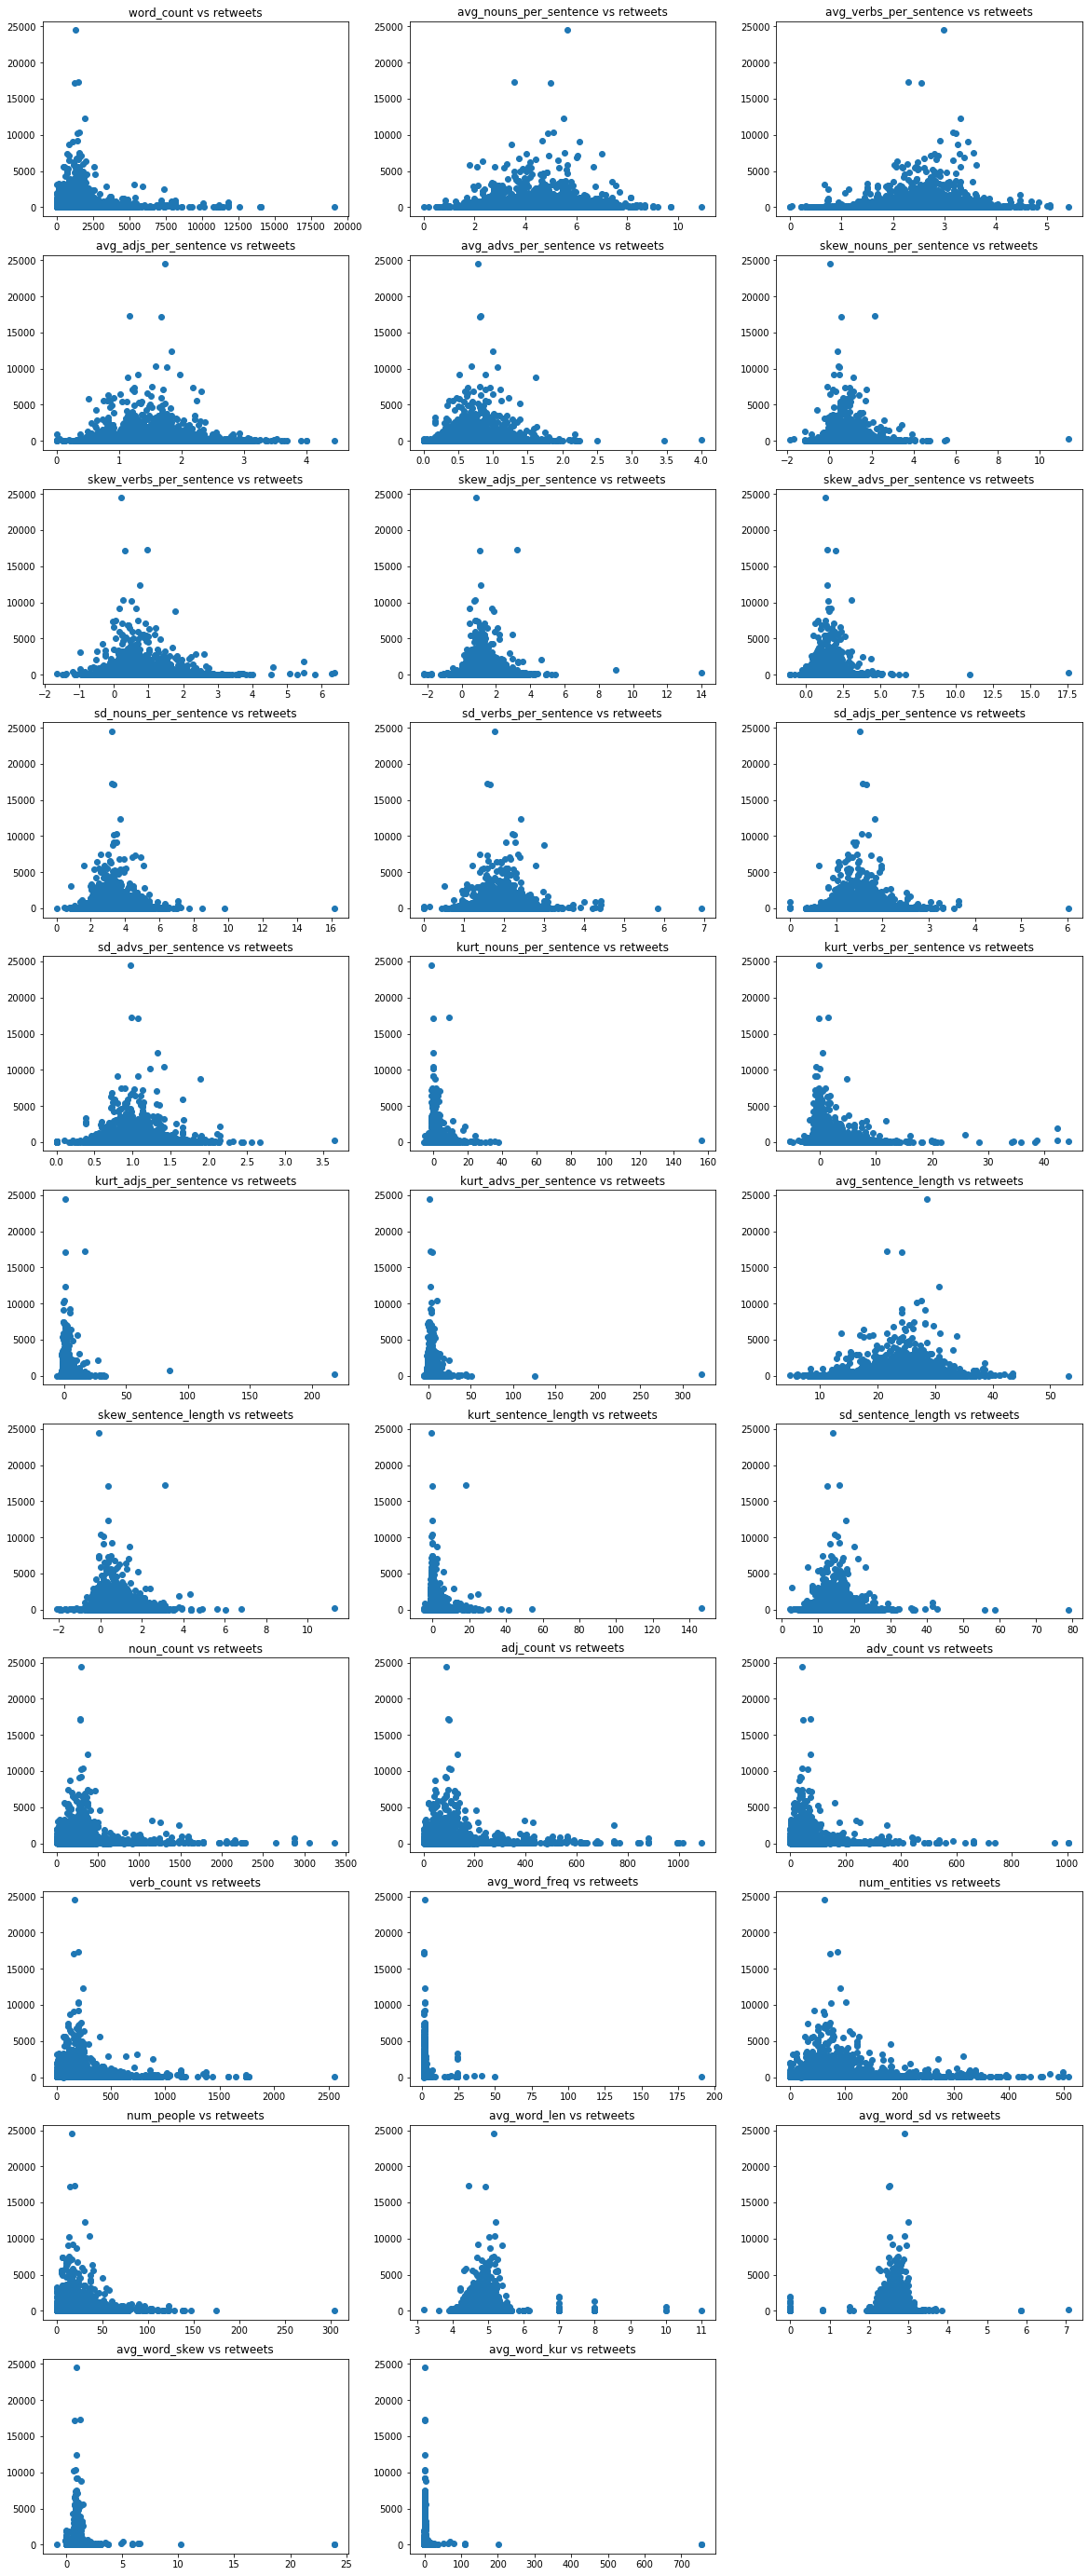

In [106]:
plot(df, titles)

In [121]:
# plot(trump, titles)

In [122]:
# plot(china, titles)

In [123]:
# plot(iowa, titles)

## Methods

In [174]:
df = pd.read_pickle("../data/feature_df.pkl")

In [175]:
### Prune Outliers

def no_outliers(df, max_retweets):
    return df[df.retweets <= max_retweets]

max_retweets = 1000

print(df.shape)
df = no_outliers(df, max_retweets)
print(df.shape)

(11027, 41)
(10673, 41)


In [176]:
print(df.shape)
display(df[0:3])

(10673, 41)


,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length,noun_count,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur
0,54,2019-10-14 23:45:05,"[Cara, Buckley, Tyler, Perry, hears, voices, i...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ...",3.687500,2.828125,1.625000,0.906250,1.003368,1.072613,0.772419,0.842893,2.894302,1.741689,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390,232,105,58,183,1.359667,72,20,4.493994,2.320905,0.984621,0.629332
1,18,2019-10-14 23:30:07,"[Robert, Leonard, Mr, Leonard, is, the, author...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753,208,89,61,118,1.448529,70,25,4.722414,2.655933,1.183618,1.660002
2,39,2019-10-14 23:15:04,"[Shuhan, Fan, and, Luther, Clement, Ms, Fan, a...",237,"[Shuhan Fan and Luther Clement, Ms Fan and Mr ...","['Shuhan', 'Fan', 'Luther', 'Clement', 'Ms', '...","{Shuhan: 'Shuhan', Fan: 'Fan', and: 'and', Lut...","Counter({'film': 6, 'Keeth': 5, 'Fan': 2, 'Lut...","{Shuhan: 'PROPN', Fan: 'PROPN', and: 'CCONJ', ...","{'ORG': ['Peter Westbrook Foundation ', 'the P...",3.333333,2.750000,1.166667,0.750000,0.252117,0.052602,1.009002,0.477594,2.839121,1.912875,1.337116,0.753778,-1.306829,-0.864689,0.204769,-0.868267,22.250000,-0.248484,-1.151573,11.250253,40,15,9,33,1.198020,14,7,4.624473,2.388066,0.949981,0.710818


In [177]:
# must optimize hyperparameters; fit.optimize 
# kendall tau is nonparametric correlation coefficient: grab two articles at  random, what is prob that article
# has bigger score as output of model also has higher engagement 
# score of 1 means that your article ranks engagement perfectly, invariant under monotonic  transformations of 
# y variable.
# kendall tau, will coxin, AUC - relationship 

# give raw words in one-hot encoding of article to deep neural network. bert & elmo (deep learning embedding)

from sklearn.model_selection import train_test_split
import scipy.stats as stats

def get_xy_split(df):
    df = df.dropna(how='any',axis=0)

    titles = ['word_count', 'avg_nouns_per_sentence',
           'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
           'avg_advs_per_sentence', 'skew_nouns_per_sentence',
           'skew_verbs_per_sentence', 'skew_adjs_per_sentence',
           'skew_advs_per_sentence', 'sd_nouns_per_sentence',
           'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
           'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
           'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
           'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
           'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
           'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
           'avg_word_len', 'avg_word_sd', 'avg_word_skew', 'avg_word_kur']

    X = df[titles].copy().values

    y = df[['retweets']].copy().values
    y = np.ravel(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = get_xy_split(df)

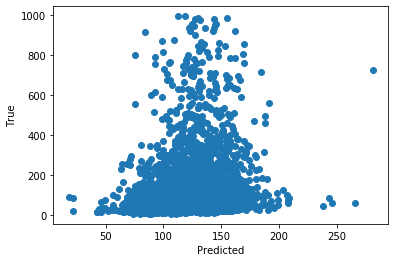

Kendall tau =  0.14949496949381386
p-value =  3.9381102588274216e-40


In [178]:
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

X_train, X_test, y_train, y_test = get_xy_split(df)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,normalize=False)

pred = reg.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

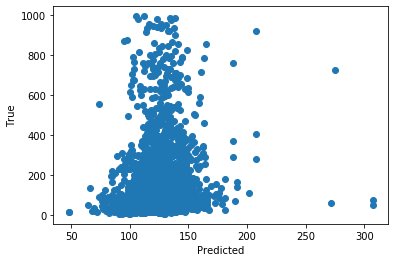

Kendall tau =  0.140974698611544
p-value =  7.057946542142796e-36


In [179]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = get_xy_split(df)

reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

pred = reg.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
# plt.ylim(0, 800)
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

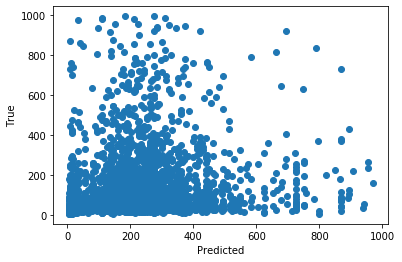

Kendall tau =  0.1241591134672232
p-value =  5.455479768946565e-28


In [180]:
# Gaussian naive Bayes
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = get_xy_split(df)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

pred = gnb.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
# plt.xlim(0, 2000)
# plt.ylim(0, 2000)
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

/Users/Kyelee/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


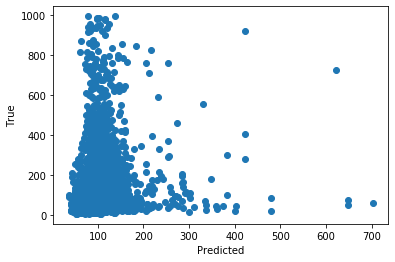

Kendall tau =  0.10187990038085665
p-value =  1.614006374254974e-19


In [181]:
# SVR 

from sklearn.svm import LinearSVR

X_train, X_test, y_train, y_test = get_xy_split(df)

clf = LinearSVR(max_iter = 10000)
clf.fit(X_train, y_train) 

pred = clf.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
# plt.xlim(0, 2000)
# plt.ylim(0, 2000)
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

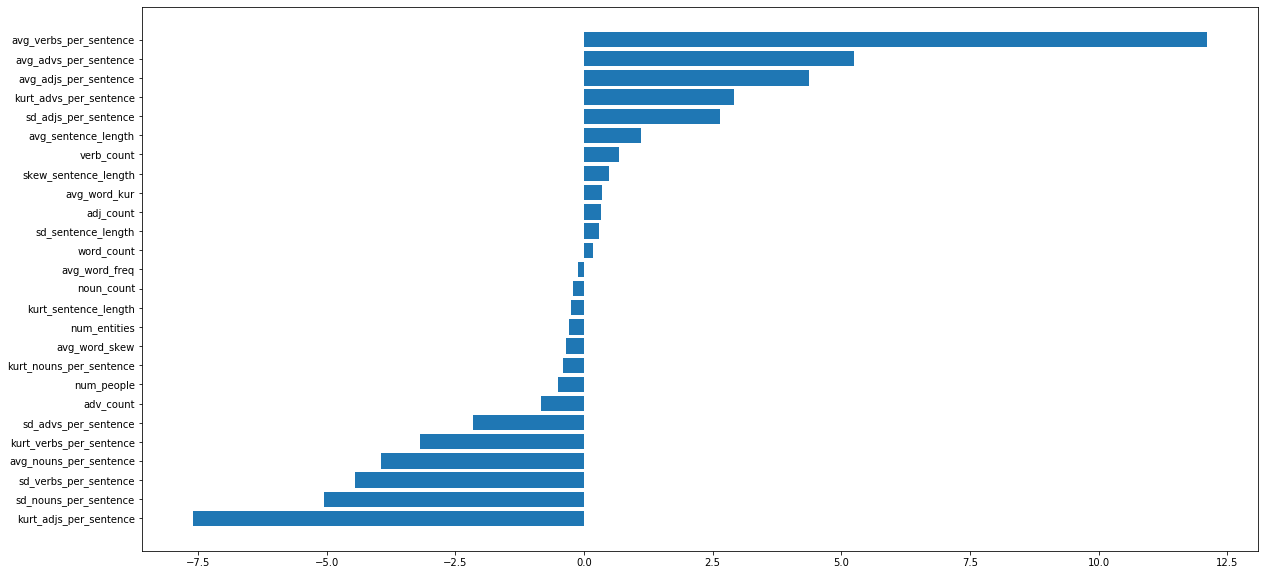

In [182]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(20,10))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(clf.coef_, titles)

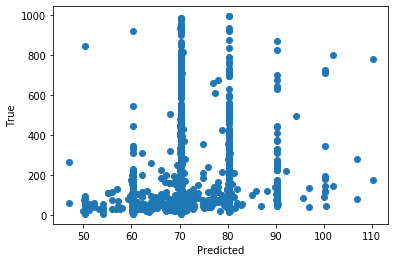

Kendall tau =  0.17103663743766775
p-value =  1.6981061637739157e-51


In [188]:
# rbf kernel 

from sklearn import svm

X_train, X_test, y_train, y_test = get_xy_split(df)

clf = svm.SVR(kernel='rbf', gamma = 'auto', C = 10)
clf.fit(X_train, y_train) 

pred = clf.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
# plt.xlim(0, 200)
# plt.ylim(0, 200)
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

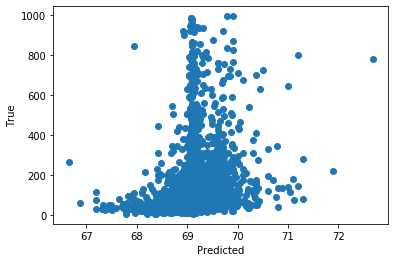

Kendall tau =  0.17890778670805302
p-value =  1.0527183137983122e-56


In [187]:
## Ensemble SVM regressor for entire dataset

from sklearn.ensemble import BaggingRegressor
from sklearn import svm
# C is penalty of error term
# optimize C and gamma? 

X_train, X_test, y_train, y_test = get_xy_split(df)

bag = BaggingRegressor(svm.SVR(kernel = 'rbf', gamma = 'auto'), max_samples=0.5, max_features=0.5)
bag.fit(X_train, y_train)

pred = bag.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
# plt.xlim(0, 200)
# plt.ylim(0, 200)
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

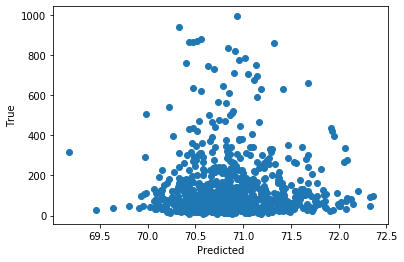

Kendall tau =  0.041884703530102166
p-value =  0.05781459221960612


In [186]:
# Ensemble regressor for TRUMP dataset
trump = get_name(df, 'PERSON', 'Trump ')
X_train, X_test, y_train, y_test = get_xy_split(trump)

from sklearn.ensemble import BaggingRegressor
from sklearn import svm
# C is penalty of error term
# optimize C and gamma? 
bag = BaggingRegressor(svm.SVR(kernel = 'rbf', gamma = 'auto'), max_samples=0.5, max_features=0.5)
bag.fit(X_train, y_train)

pred = bag.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
# plt.xlim(0, 200)
# plt.ylim(0, 200)
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

In [155]:
# ensemble regressor with data transform

from sklearn.ensemble import BaggingRegressor
from sklearn import svm

df = pd.read_pickle("../data/feature_df.pkl")
df = no_outliers(df, 1000)

titles = ['word_count', 'avg_nouns_per_sentence',
           'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
           'avg_advs_per_sentence', 'sd_nouns_per_sentence',
           'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
           'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
           'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
           'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
           'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
           'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
           'avg_word_skew', 'avg_word_kur']

df_transform = df
c = 1e-3
for i in range(len(titles)):
    df_transform[titles[i] + "_inverse"] = df[titles[i]].apply(lambda x: 1/(x+c))

for i in range(len(titles)):
    df_transform[titles[i] + "_sqrt"] = df[titles[i]].apply(lambda x: np.sqrt(x))
    
# for i in range(len(titles)):
#     df_transform[titles[i] + "_log"] = df[titles[i]].apply(lambda x: np.log(x+c))

display(df_transform[0:3])

,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length,noun_count,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur,word_count_inverse,avg_nouns_per_sentence_inverse,avg_verbs_per_sentence_inverse,avg_adjs_per_sentence_inverse,avg_advs_per_sentence_inverse,sd_nouns_per_sentence_inverse,sd_verbs_per_sentence_inverse,sd_adjs_per_sentence_inverse,sd_advs_per_sentence_inverse,kurt_nouns_per_sentence_inverse,kurt_verbs_per_sentence_inverse,kurt_adjs_per_sentence_inverse,kurt_advs_per_sentence_inverse,avg_sentence_length_inverse,skew_sentence_length_inverse,kurt_sentence_length_inverse,sd_sentence_length_inverse,noun_count_inverse,adj_count_inverse,adv_count_inverse,verb_count_inverse,avg_word_freq_inverse,num_entities_inverse,num_people_inverse,avg_word_skew_inverse,avg_word_kur_inverse,word_count_sqrt,avg_nouns_per_sentence_sqrt,avg_verbs_per_sentence_sqrt,avg_adjs_per_sentence_sqrt,avg_advs_per_sentence_sqrt,sd_nouns_per_sentence_sqrt,sd_verbs_per_sentence_sqrt,sd_adjs_per_sentence_sqrt,sd_advs_per_sentence_sqrt,kurt_nouns_per_sentence_sqrt,kurt_verbs_per_sentence_sqrt,kurt_adjs_per_sentence_sqrt,kurt_advs_per_sentence_sqrt,avg_sentence_length_sqrt,skew_sentence_length_sqrt,kurt_sentence_length_sqrt,sd_sentence_length_sqrt,noun_count_sqrt,adj_count_sqrt,adv_count_sqrt,verb_count_sqrt,avg_word_freq_sqrt,num_entities_sqrt,num_people_sqrt,avg_word_skew_sqrt,avg_word_kur_sqrt
0,54,2019-10-14 23:45:05,"[Cara, Buckley, Tyler, Perry, hears, voices, i...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ...",3.687500,2.828125,1.625000,0.906250,1.003368,1.072613,0.772419,0.842893,2.894302,1.741689,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390,232,105,58,183,1.359667,72,20,4.493994,2.320905,0.984621,0.629332,0.000751,0.271113,0.353466,0.615006,1.102232,0.345387,0.573826,0.752804,0.980237,1.174474,0.309656,1.210725,-2.245527,0.040326,1.246628,0.877527,0.071152,0.004310,0.009524,0.017241,0.005464,0.734933,0.013889,0.049998,1.014589,1.586466,36.496575,1.920286,1.681703,1.274755,0.951972,1.701265,1.319731,1.152114,1.009535,0.922196,1.796773,0.908268,NaN,4.979646,0.895078,1.067036,3.748785,15.231546,10.246951,7.615773,13.527749,1.166048,8.485281,4.472136,0.992280,0.793304
1,18,2019-10-14 23:30:07,"[Robert, Leonard, Mr, Leonard, is, the, author...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753,208,89,61,118,1.448529,70,25,4.722414,2.655933,1.183618,1.660002,0.000862,0.325475,0.613658,0.744127,1.092555,0.415865,0.686184,0.734326,1.010136,1.191915,0.614937,1.057162,0.738504,0.050502,2.824568,-2.820109,0.099081,0.004808,0.011236,0.016393,0.008475,0.689879,0.014286,0.039998,0.844154,0.602046,34.058773,1.752549,1.276155,1.15

getting rid of 8591 null columns


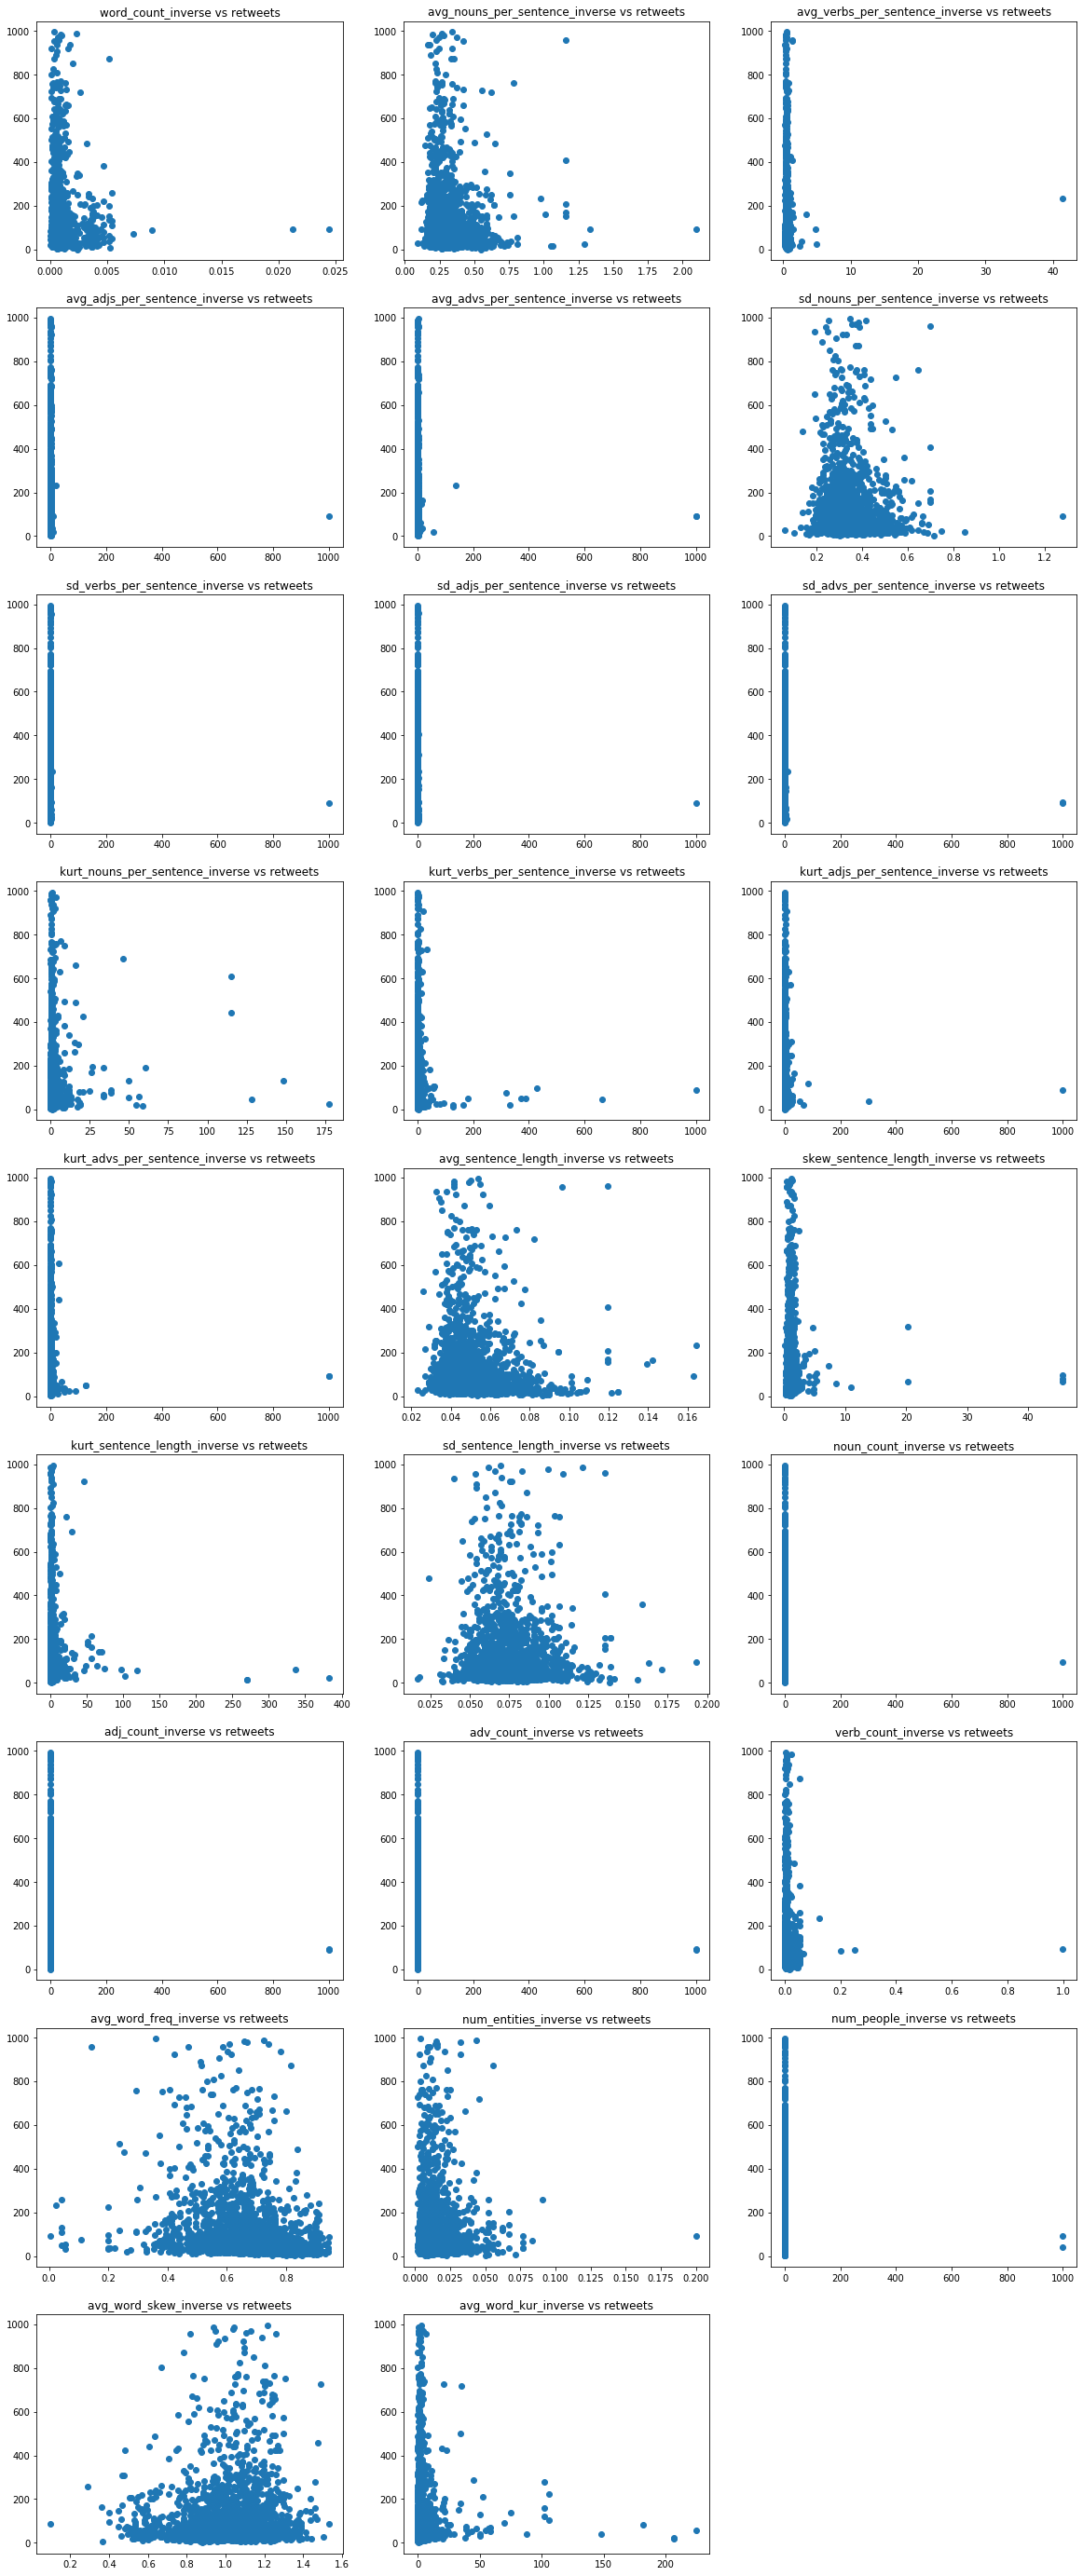

In [192]:
titles = ['word_count', 'avg_nouns_per_sentence',
           'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
           'avg_advs_per_sentence', 'sd_nouns_per_sentence',
           'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
           'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
           'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
           'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
           'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
           'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
           'avg_word_skew', 'avg_word_kur']

transforms = [i+'_inverse' for i in titles]

plot(df_transform, transforms)

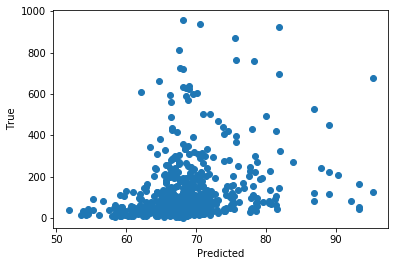

Kendall tau =  0.23048309600473174
p-value =  1.907115499706104e-19


In [157]:
X_train, X_test, y_train, y_test = get_xy_split(df_transform)

bag = BaggingRegressor(svm.SVR(kernel = 'rbf', gamma = 'auto', C = 15), max_samples=0.5, max_features=0.5)
bag.fit(X_train, y_train)

pred = bag.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
# plt.xlim(0, 200)
# plt.ylim(0, 200)
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

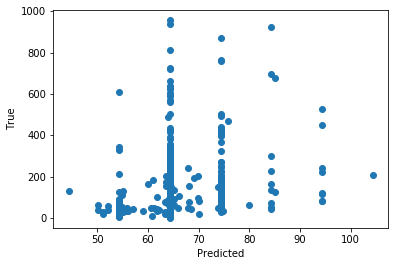

Kendall tau =  0.250724663492209
p-value =  4.851177777574923e-21


In [159]:
# rbf kernel 

from sklearn import svm

X_train, X_test, y_train, y_test = get_xy_split(df_transform)

clf = svm.SVR(kernel='rbf', gamma = 'auto', C = 10)
clf.fit(X_train, y_train) 

pred = clf.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
# plt.xlim(0, 200)
# plt.ylim(0, 200)
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)